In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mir_utils as miru
import feature_functions as ff
import madmom as md
import librosa
import multiprocessing
import sounddevice as sd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Audio
import os
sr=48000
df=miru.audioFrames(loadCache=True)
save_dir="cnn_data"

def getRandomAudio(dcategories="any",fdf=df):
    #dcategories=string of categories you want, comma seperated->eg:"kick,rim,snare"
    if dcategories != "any": 
        fdf=fdf[fdf["label"].isin(dcategories.split(","))]
    random_row = np.random.randint(fdf.shape[0])
    return fdf.iloc[random_row]

def cutAudio(x,num_samples=sr):
    xt,i=librosa.effects.trim(x, top_db=50)
    nTrimmed=len(x)-len(xt)
    xt=librosa.util.normalize(xt)
    xt=xt[0:num_samples]
    new_x =np.pad(xt,(0,num_samples-xt.shape[0]),'constant')
    return new_x,nTrimmed
    

In [2]:
df

,label,path,audio
0,clap,./dk_data/clap/1005-MXR_Computer_Rhythm_185-Ma...,"[-5.3273096e-05, 9.7988384e-05, -0.00022890793..."
1,clap,./dk_data/clap/1005-Yamaha_RX-11-MaxV_-_RX11_C...,"[0.0012242286, 0.040233005, -0.0024631436, -0...."
2,clap,./dk_data/clap/102-MultiMoog-MaxV_-_JeeesuosCl...,"[0.011761859, -0.015967432, 0.0005397326, -0.0..."
3,clap,./dk_data/clap/1021-Akai_XR10-XR10Clap.wav,"[3.0486694e-05, -0.0025696023, -0.011185456, -..."
4,clap,./dk_data/clap/10330-Oberheim_DX-DXClap.wav,"[2.0797363e-05, -0.0011080893, -0.0036181042, ..."
...,...,...,...
12368,stacks,./dk_data/stacks/199.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12369,stacks,./dk_data/stacks/19.wav.~3~,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12370,stacks,./dk_data/stacks/19.wav,"[4.0767628e-07, -3.4729783e-05, -0.00010333673..."
12371,stacks,./dk_data/stacks/1.wav.~3~,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


label                                               stacks
path                         ./dk_data/stacks/1843.wav.~3~
audio    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 12021, dtype: object (48000,) (100, 120)


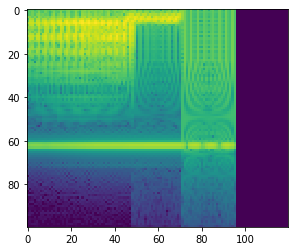

In [59]:
# this function a melspec from any 1 second audio 
# uncertainty: what's the best value for n_fft?
# time-frequency localization tradeoff 
num_bins=100
# num_samples=2*img_dim**2-img_dim

def audToImage(x):
    D=librosa.stft(x,n_fft=num_bins**2,win_length=num_bins**2,hop_length=int(num_bins*4)+1)
    S = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=num_bins)
    S_dB = librosa.power_to_db(np.abs(S))
    return S_dB

audio_row=getRandomAudio(dcategories="any")
x,num_trimmed=cutAudio(audio_row["audio"])
z=audToImage(x)

print(audio_row,x.shape,z.shape)
plt.imshow(z)
Audio(x,rate=sr, autoplay=True)

In [78]:
audio_row=getRandomAudio(dcategories="any")
x,num_trimmed=cutAudio(audio_row["audio"])
num_samples=44000
xt,i=librosa.effects.trim(x, top_db=50)
xt=librosa.util.normalize(xt)
x=xt[0:num_samples]
fl=1000
hl=int(fl/2)

x,i=librosa.effects.trim(x, top_db=30, frame_length=fl, hop_length=hl)
# print(audio_row)
env=librosa.feature.rms(y=x)
# print(env.shape)
plt.figure(figsize=(15, 5))


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [79]:
#make directoies
folders=df.label.unique()
for f in folders:
    directory="./%s/%s/%s"%(save_dir,"train",f)
    if not os.path.exists(directory):
        os.makedirs(directory)
    directory="./%s/%s/%s"%(save_dir,"test",f)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [80]:
#convert all audio in dataframe to images and put them in folders depending on the labels
df = df.sample(frac=1).reset_index(drop=True) #shuffling
trainPercent=0.8
testPercent=0.2
data_type="train"

for i,r in df.iterrows():
    fname=r["path"].split("/")[-1]
    if i>int(trainPercent*df.shape[0]):
        data_type="test"
    p="./%s/%s/%s/%s.png"%(save_dir,data_type,r["label"],fname)
    x,num_trimmed=cutAudio(r["audio"])
    z=audToImage(x)
    I=np.asarray(z)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(p)

/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
